L’objectif est de faire la partie “optimisation + sélection du modèle + explication + analyse d’erreurs”, en restant cohérent avec les résultats des baselines : ici, le meilleur modèle est Ridge avec une cible transformée log1p(SalePrice). 

On commence donc par recharger le dataset train.csv, puis on sépare les variables explicatives X et la cible y = SalePrice. On fait ensuite un split train/test (ex. 80/20) avant tout prétraitement pour éviter le data leakage (fuite d’information du test vers l’entraînement). Après le split, on construit un pipeline de prétraitement avec ColumnTransformer : pour les variables numériques, on remplit les valeurs manquantes par la médiane (robuste aux outliers) 

puis on applique un StandardScaler (important pour Ridge car c’est un modèle linéaire régularisé sensible à l’échelle des variables) ; pour les variables catégorielles, on remplit les valeurs manquantes par la valeur la plus fréquente puis on applique un OneHotEncoder (avec handle_unknown="ignore" pour gérer les catégories jamais vues).

Ensuite, on applique la transformation de la cible : on entraîne Ridge sur y_train_log = log1p(y_train) car SalePrice est fortement asymétrique à droite (skew ≈ 1.88) et la transformation log1p réduit l’influence des valeurs extrêmes et rend la relation plus “linéaire”, ce qui aide souvent un modèle comme Ridge. 

On entraîne d’abord une baseline Ridge + log1p pour avoir un point de comparaison. Puis on réalise le tuning systématique des hyperparamètres avec GridSearchCV : on explore plusieurs valeurs de alpha (force de régularisation) et fit_intercept en utilisant une validation croisée (CV=5) et une métrique de score neg_root_mean_squared_error calculée sur l’échelle log (c’est normal, car le modèle est entraîné sur la cible log). 


Une fois le meilleur pipeline trouvé, on fait une évaluation finale sur le jeu de test : on prédit en log, puis on revient à l’échelle des prix avec expm1 afin de calculer des métriques compréhensibles en euros (RMSE/MAE/R²). On enregistre ensuite les résultats dans des fichiers CSV (baseline_ridge_log1p_metrics.csv, final_metrics.csv, baseline_vs_tuned_summary.csv) et on sauvegarde tous les résultats de CV (tuning_cv_results.csv) pour prouver la recherche systématique et comparer baseline vs tuned.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Racine du projet (fonctionne depuis /notebooks ou depuis la racine)
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()

DATA_RAW = ROOT / "data" / "raw"
FIG_DIR = ROOT / "reports" / "figures"
METRICS_DIR = ROOT / "reports" / "metrics"
MODELS_DIR = ROOT / "models"

FIG_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "SalePrice"
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5

print("ROOT:", ROOT)
print("train.csv exists:", (DATA_RAW / "train.csv").exists())


ROOT: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice
train.csv exists: True


In [2]:
path = "../data/raw/train.csv"
df_house = pd.read_csv(path)
display(df_house.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#Split train/test anti leakage
from sklearn.model_selection import train_test_split

X = df_house.drop(columns=[TARGET])
y = df_house[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((1168, 80), (292, 80))

In [10]:
# Preprocess imputation + onehot + scaling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'B...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

Fonctions métriques sur échelle PRIX

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def regression_metrics(y_true_price, y_pred_price):
    return {
        "RMSE": mean_squared_error(y_true_price, y_pred_price, squared=False),
        "MAE": mean_absolute_error(y_true_price, y_pred_price),
        "R2": r2_score(y_true_price, y_pred_price),
    }


Baseline Ridge + log1p for target

In [12]:
from sklearn.linear_model import Ridge

y_train_log = np.log1p(y_train)

baseline_ridge_log = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge())
])

baseline_ridge_log.fit(X_train, y_train_log)

preds_log_base = baseline_ridge_log.predict(X_test)
preds_base_price = np.expm1(preds_log_base)  # retour en prix

baseline_metrics = regression_metrics(y_test, preds_base_price)
baseline_metrics


d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'RMSE': 23879.545484278417,
 'MAE': 15754.377040396776,
 'R2': 0.9256573088115325}

Tuning Ridge GridSearchCV sur log1p(target)

In [13]:
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge())
])

param_grid = {
    "model__alpha": [0.1, 1, 3, 10, 30, 100, 300, 1000],
    "model__fit_intercept": [True, False]
}

search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # RMSE sur y_log
    cv=CV_FOLDS,
    n_jobs=-1
)

search.fit(X_train, y_train_log)

best_model = search.best_estimator_
best_params = search.best_params_
best_cv_rmse_log = -search.best_score_

best_params, best_cv_rmse_log


({'model__alpha': 30, 'model__fit_intercept': True}, 0.14446303684952916)

Évaluation finale en prix et exports 

In [14]:
preds_log = best_model.predict(X_test)
preds_price = np.expm1(preds_log)  # retour en euros

final_metrics = regression_metrics(y_test, preds_price)
final_metrics


d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'RMSE': 25774.41904501153, 'MAE': 16726.09676487633, 'R2': 0.9133908181785826}

In [15]:
# Export métriques baseline & tuned (sur échelle prix)
pd.DataFrame([baseline_metrics]).assign(Stage="baseline_ridge_log1p").to_csv(
    METRICS_DIR / "baseline_ridge_log1p_metrics.csv", index=False
)

pd.DataFrame([final_metrics]).assign(Stage="tuned_ridge_log1p").to_csv(
    METRICS_DIR / "final_metrics.csv", index=False
)

# Export résultats CV (sur échelle log)
pd.DataFrame(search.cv_results_).to_csv(METRICS_DIR / "tuning_cv_results.csv", index=False)

print("Saved:",
      METRICS_DIR / "baseline_ridge_log1p_metrics.csv",
      METRICS_DIR / "final_metrics.csv",
      METRICS_DIR / "tuning_cv_results.csv")


Saved: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\metrics\baseline_ridge_log1p_metrics.csv d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\metrics\final_metrics.csv d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\metrics\tuning_cv_results.csv


Baseline vs Tuned (tableau et gain)

In [16]:
summary = pd.DataFrame([
    {"Stage": "baseline_ridge_log1p", **baseline_metrics},
    {"Stage": "tuned_ridge_log1p", **final_metrics},
])

summary["RMSE_gain"] = summary["RMSE"].iloc[0] - summary["RMSE"].iloc[1]
summary


,Stage,RMSE,MAE,R2,RMSE_gain
0,baseline_ridge_log1p,23879.545484,15754.377040,0.925657,-1894.873561
1,tuned_ridge_log1p,25774.419045,16726.096765,0.913391,-1894.873561


In [17]:
summary.to_csv(METRICS_DIR / "baseline_vs_tuned_summary.csv", index=False)
print("Saved:", METRICS_DIR / "baseline_vs_tuned_summary.csv")


Saved: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\metrics\baseline_vs_tuned_summary.csv


Importance des variables 

In [18]:
preprocessor = best_model.named_steps["preprocess"]
ridge = best_model.named_steps["model"]

feature_names = preprocessor.get_feature_names_out()
coefs = ridge.coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

top20 = coef_df.head(20)
top20


,feature,coef,abs_coef
4,num__OverallQual,0.079688,0.079688
70,cat__Neighborhood_Crawfor,0.060615,0.060615
16,num__GrLivArea,0.051860,0.051860
135,cat__Exterior1st_BrkFace,0.051123,0.051123
86,cat__Neighborhood_StoneBr,0.051018,0.051018
71,cat__Neighborhood_Edwards,-0.050922,0.050922
232,cat__Functional_Typ,0.048413,0.048413
80,cat__Neighborhood_NridgHt,0.045448,0.045448
26,num__GarageCars,0.045423,0.045423
125,cat__RoofMatl_ClyTile,-0.041463,0.041463


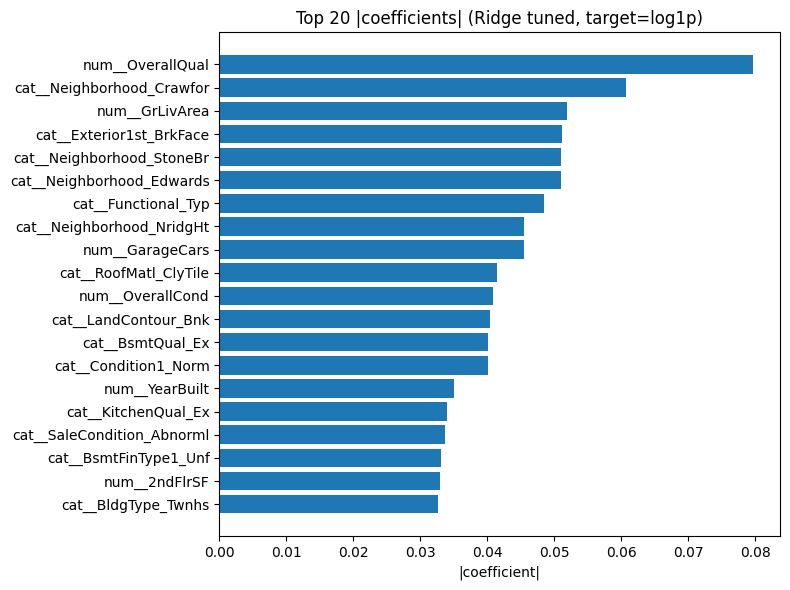

Saved: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\figures\ridge_top20_coefficients.png d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\metrics\ridge_top20_coefficients.csv


In [19]:
plt.figure(figsize=(8,6))
plt.barh(top20["feature"][::-1], top20["abs_coef"][::-1])
plt.title("Top 20 |coefficients| (Ridge tuned, target=log1p)")
plt.xlabel("|coefficient|")
plt.tight_layout()
plt.savefig(FIG_DIR / "ridge_top20_coefficients.png", dpi=150, bbox_inches="tight")
plt.show()

top20.to_csv(METRICS_DIR / "ridge_top20_coefficients.csv", index=False)
print("Saved:",
      FIG_DIR / "ridge_top20_coefficients.png",
      METRICS_DIR / "ridge_top20_coefficients.csv")


Analyse d’erreurs 

In [20]:
error_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": preds_price
})
error_df["error"] = error_df["y_true"] - error_df["y_pred"]
error_df["abs_error"] = error_df["error"].abs()

top10 = error_df.sort_values("abs_error", ascending=False).head(10)
top10


,y_true,y_pred,error,abs_error
74,611657,428724.865811,182932.134189,182932.134189
139,755000,636069.129444,118930.870556,118930.870556
168,556581,447231.109557,109349.890443,109349.890443
260,395000,290346.412092,104653.587908,104653.587908
109,135000,210916.928676,-75916.928676,75916.928676
278,143000,216582.357228,-73582.357228,73582.357228
43,253293,325051.734839,-71758.734839,71758.734839
140,403000,331299.701828,71700.298172,71700.298172
270,465000,397453.036460,67546.963540,67546.963540
76,348000,289464.576350,58535.423650,58535.423650


In [21]:
top10.to_csv(METRICS_DIR / "top10_errors.csv", index=False)
print("Saved:", METRICS_DIR / "top10_errors.csv")


Saved: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\metrics\top10_errors.csv


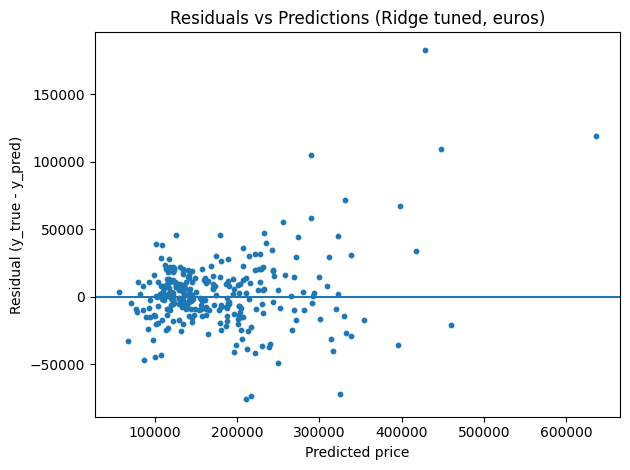

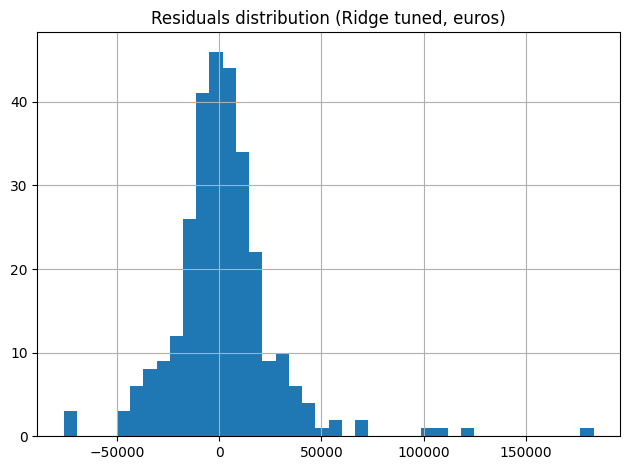

In [22]:
plt.figure()
plt.scatter(error_df["y_pred"], error_df["error"], s=10)
plt.axhline(0)
plt.title("Residuals vs Predictions (Ridge tuned, euros)")
plt.xlabel("Predicted price")
plt.ylabel("Residual (y_true - y_pred)")
plt.tight_layout()
plt.savefig(FIG_DIR / "residuals_vs_pred.png", dpi=150, bbox_inches="tight")
plt.show()

plt.figure()
error_df["error"].hist(bins=40)
plt.title("Residuals distribution (Ridge tuned, euros)")
plt.tight_layout()
plt.savefig(FIG_DIR / "residuals_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


In [23]:
error_df["price_bin"] = pd.qcut(error_df["y_true"], q=4, labels=["Q1 (bas)", "Q2", "Q3", "Q4 (haut)"])

group_stats = error_df.groupby("price_bin").agg(
    count=("abs_error", "count"),
    mean_abs_error=("abs_error", "mean"),
    median_abs_error=("abs_error", "median"),
    rmse=("error", lambda x: np.sqrt(np.mean(x**2)))
).reset_index()

group_stats


C:\Users\nadeg\AppData\Local\Temp\ipykernel_20240\1367479149.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = error_df.groupby("price_bin").agg(


,price_bin,count,mean_abs_error,median_abs_error,rmse
0,Q1 (bas),75,10365.308198,7556.909100,14649.958369
1,Q2,71,12746.033952,9015.510337,18714.228337
2,Q3,73,15953.905154,13726.542491,19640.972381
3,Q4 (haut),73,27904.365120,19523.018477,41356.817908


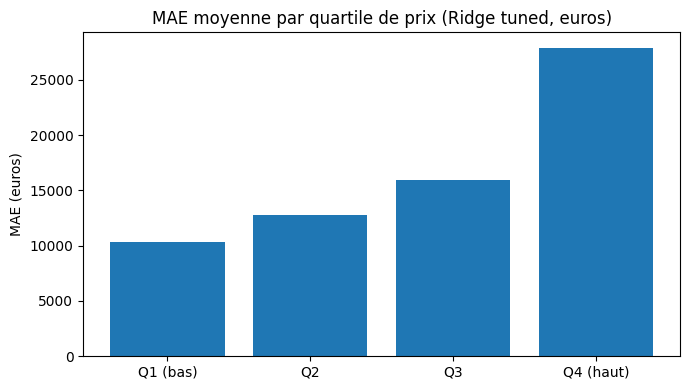

Saved: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\figures\mae_by_price_quartile.png d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\reports\metrics\error_by_price_quartile.csv


In [24]:
plt.figure(figsize=(7,4))
plt.bar(group_stats["price_bin"], group_stats["mean_abs_error"])
plt.title("MAE moyenne par quartile de prix (Ridge tuned, euros)")
plt.ylabel("MAE (euros)")
plt.tight_layout()
plt.savefig(FIG_DIR / "mae_by_price_quartile.png", dpi=150, bbox_inches="tight")
plt.show()

group_stats.to_csv(METRICS_DIR / "error_by_price_quartile.csv", index=False)
print("Saved:",
      FIG_DIR / "mae_by_price_quartile.png",
      METRICS_DIR / "error_by_price_quartile.csv")


Sauvegarde modèle final

In [26]:
from joblib import dump

dump(best_model, MODELS_DIR / "final_model.joblib")
print("Saved:", MODELS_DIR / "final_model.joblib")


Saved: d:\DeveloppementWeb\Hexagone\Programmation avancee\ProgrammationAvancee_IA_M1_HousePrice\models\final_model.joblib
